In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
%matplotlib inline

In [3]:
DATA_PATH = '/Users/shovitraj/Github/Python/MagNet_data/'

In [4]:
dst = pd.read_csv(DATA_PATH +"dst_labels.csv")
dst.timedelta = pd.to_timedelta(dst.timedelta)
dst.set_index(["period", "timedelta"], inplace=True)

sunspots = pd.read_csv(DATA_PATH + "sunspots.csv")
sunspots.timedelta = pd.to_timedelta(sunspots.timedelta)
sunspots.set_index(["period", "timedelta"], inplace=True)

solar_wind = pd.read_csv(DATA_PATH + "solar_wind.csv")
solar_wind.timedelta = pd.to_timedelta(solar_wind.timedelta)
solar_wind.set_index(["period", "timedelta"], inplace=True)

In [5]:
from numpy.random import seed
from tensorflow.random import set_seed

In [6]:
seed(2020)
set_seed(2021)

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
# subset of solar wind features to use for modeling
SOLAR_WIND_FEATURES = [
    "bx_gse",
    "by_gse",
    "bz_gse",
    "speed",
    "density",
    "temperature",
    'theta_gse',

]

# all of the features we'll use, including sunspot numbers
XCOLS = (
    [col + "_mean" for col in SOLAR_WIND_FEATURES]
    + [col + "_std" for col in SOLAR_WIND_FEATURES]
    + ["smoothed_ssn"]
)

XCOLS_NEW = (['bx_gse_std', 'by_gse_std',
       'bz_gse_mean', 'bz_gse_std', 'speed_mean', 'speed_std', 'density_mean',
       'temperature_mean', 'temperature_std', 'theta_gse_mean',
        'smoothed_ssn'])

def impute_features(feature_df):
    """Imputes data using the following methods:
    - `smoothed_ssn`: forward fill
    - `solar_wind`: interpolation
    """
    # forward fill sunspot data for the rest of the month
    feature_df.smoothed_ssn = feature_df.smoothed_ssn.fillna(method="ffill")
    # interpolate between missing solar wind values
    feature_df = feature_df.interpolate()
    return feature_df


def aggregate_hourly(feature_df, aggs=["mean", "std"]):
    """Aggregates features to the floor of each hour using mean and standard deviation.
    e.g. All values from "11:00:00" to "11:59:00" will be aggregated to "11:00:00".
    """
    # group by the floor of each hour use timedelta index
    agged = feature_df.groupby(
        ["period", feature_df.index.get_level_values(1).floor("H")]
    ).agg(aggs)
    # flatten hierachical column index
    agged.columns = ["_".join(x) for x in agged.columns]
    return agged


def preprocess_features(solar_wind, sunspots, scaler=None, subset=None):
    """
    Preprocessing steps:
        - Subset the data
        - Aggregate hourly
        - Join solar wind and sunspot data
        - Scale using standard scaler
        - Impute missing values
    """
    # select features we want to use
    if subset:
        solar_wind = solar_wind[subset]

    # aggregate solar wind data and join with sunspots
    hourly_features = aggregate_hourly(solar_wind).join(sunspots)
    hourly_xcols = hourly_features[XCOLS_NEW]
    # subtract mean and divide by standard deviation
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(hourly_xcols)

    normalized = pd.DataFrame(
        scaler.transform(hourly_xcols),
        index=hourly_xcols.index,
        columns=hourly_xcols.columns,
    )

    # impute missing values
    imputed = impute_features(normalized)

    # we want to return the scaler object as well to use later during prediction
    return imputed, scaler

In [9]:
features, scaler = preprocess_features(solar_wind, sunspots, subset=SOLAR_WIND_FEATURES)
print(features.shape)
features.head()

(139872, 11)


bx_gse_std  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                          
train_a 0 days 00:00:00   -0.381502    0.031658     0.300358   -0.651645   
        0 days 01:00:00   -0.867747   -0.272971     0.446103   -0.517913   
        0 days 02:00:00   -1.114317   -0.822786     0.770174   -0.876490   
        0 days 03:00:00   -0.783042    0.341156     0.621194   -0.290211   
        0 days 04:00:00   -0.484910    1.023019     0.467629   -0.478080   

                         speed_mean  speed_std  density_mean  \
period  timedelta                                              
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827   
        0 days 01:00:00   -0.986904   0.995063     -0.861692   
        0 days 02:00:00   -1.013548   0.554085     -0.846222   
        0 days 03:00:00   -0.826469  -0.211185     -0.404306   
        0 days 04:00:00   -0.601238   1.016033     -0.371487   

                         temperature_mean  temperature_std  theta_gse_mean  \
period  timedelta                                                            
train_a 0 days 00:00:00         -0.375267         0.383941        0.262090   
        0 days 01:00:00         -0.479430         0.953178        0.378546   
        0 days 02:00:00         -0.574831        -0.192518        0.607449   
        0 days 03:00:00         -0.324709         0.325491        0.491460   
        0 days 04:00:00         -0.313432         0.201600        0.466528   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444  
        0 days 03:00:00      0.139444  
        0 days 04:00:00      0.139444

<AxesSubplot:>

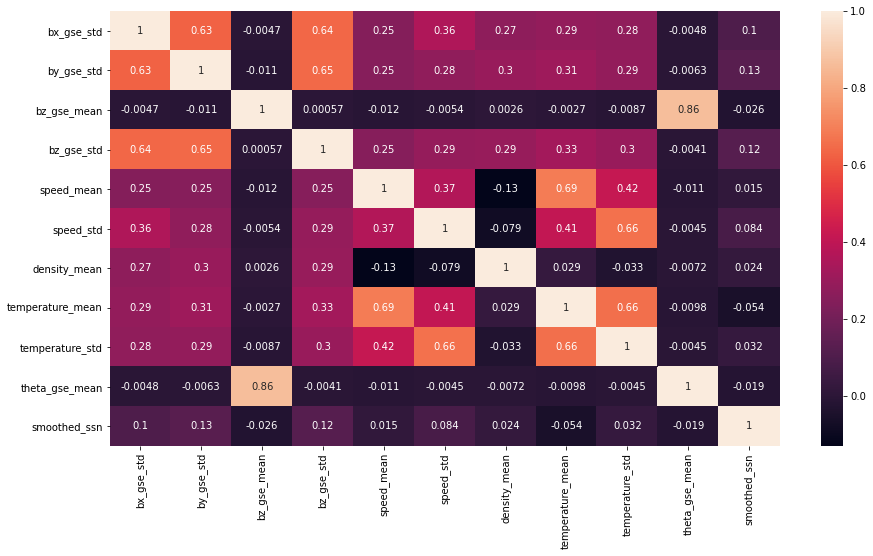

In [10]:
import seaborn as sns
a=features.corr()
plt.figure(figsize=[15,8])
sns.heatmap(a,annot=True)

In [11]:
# check to make sure missing values are filled
assert (features.isna().sum() == 0).all()

In [12]:
YCOLS = ["t0", "t1"]


def process_labels(dst):
    y = dst.copy()
    y["t1"] = y.groupby("period").dst.shift(-1)
    y.columns = YCOLS
    return y


labels = process_labels(dst)
labels.head()

t0    t1
period  timedelta                
train_a 0 days 00:00:00  -7 -10.0
        0 days 01:00:00 -10 -10.0
        0 days 02:00:00 -10  -6.0
        0 days 03:00:00  -6  -2.0
        0 days 04:00:00  -2   3.0

In [13]:
data = labels.join(features)
data.head()

t0    t1  bx_gse_std  by_gse_std  bz_gse_mean  \
period  timedelta                                                        
train_a 0 days 00:00:00  -7 -10.0   -0.381502    0.031658     0.300358   
        0 days 01:00:00 -10 -10.0   -0.867747   -0.272971     0.446103   
        0 days 02:00:00 -10  -6.0   -1.114317   -0.822786     0.770174   
        0 days 03:00:00  -6  -2.0   -0.783042    0.341156     0.621194   
        0 days 04:00:00  -2   3.0   -0.484910    1.023019     0.467629   

                         bz_gse_std  speed_mean  speed_std  density_mean  \
period  timedelta                                                          
train_a 0 days 00:00:00   -0.651645   -0.738546   0.862524     -0.775827   
        0 days 01:00:00   -0.517913   -0.986904   0.995063     -0.861692   
        0 days 02:00:00   -0.876490   -1.013548   0.554085     -0.846222   
        0 days 03:00:00   -0.290211   -0.826469  -0.211185     -0.404306   
        0 days 04:00:00   -0.478080   -0.601238   1.016033     -0.371487   

                         temperature_mean  temperature_std  theta_gse_mean  \
period  timedelta                                                            
train_a 0 days 00:00:00         -0.375267         0.383941        0.262090   
        0 days 01:00:00         -0.479430         0.953178        0.378546   
        0 days 02:00:00         -0.574831        -0.192518        0.607449   
        0 days 03:00:00         -0.324709         0.325491        0.491460   
        0 days 04:00:00         -0.313432         0.201600        0.466528   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444  
        0 days 03:00:00      0.139444  
        0 days 04:00:00      0.139444

<AxesSubplot:>

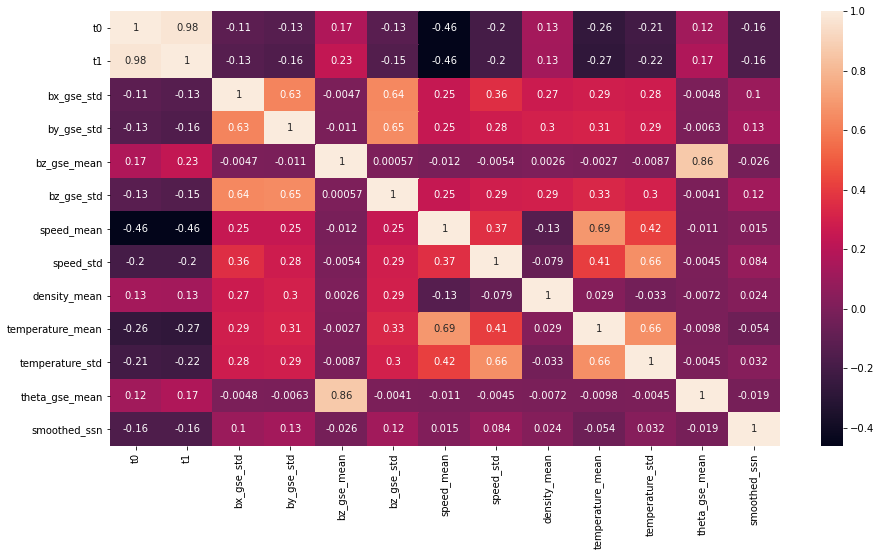

In [14]:
import seaborn as sns
ab=data.corr()
plt.figure(figsize=[15,8])
sns.heatmap(ab,annot=True)

In [15]:
# data.columns

In [16]:
# data=data[['t0', 't1','bx_gse_std', 'by_gse_std',
#        'bz_gse_mean', 'bz_gse_std', 'speed_mean', 'speed_std', 'density_mean',
#        'temperature_mean', 'temperature_std', 'theta_gse_mean',
#         'smoothed_ssn']]

In [17]:
def get_train_test_val(data, test_per_period, val_per_period):
    """Splits data across periods into train, test, and validation"""
    # assign the last `test_per_period` rows from each period to test
    test = data.groupby("period").tail(test_per_period)
    interim = data[~data.index.isin(test.index)]
    # assign the last `val_per_period` from the remaining rows to validation
    val = interim.groupby("period").tail(val_per_period)
    # the remaining rows are assigned to train
    train = interim[~interim.index.isin(val.index)]
    return train, test, val


train, test, val = get_train_test_val(data, test_per_period=6_000, val_per_period=6_000)


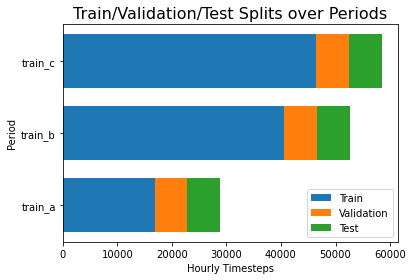

In [18]:
ind = [0, 1, 2]
names = ["train_a", "train_b", "train_c"]
width = 0.75
train_cnts = [len(df) for _, df in train.groupby("period")]
val_cnts = [len(df) for _, df in val.groupby("period")]
test_cnts = [len(df) for _, df in test.groupby("period")]

p1 = plt.barh(ind, train_cnts, width)
p2 = plt.barh(ind, val_cnts, width, left=train_cnts)
p3 = plt.barh(ind, test_cnts, width, left=np.add(val_cnts, train_cnts).tolist())

plt.yticks(ind, names)
plt.ylabel("Period")
plt.xlabel("Hourly Timesteps")
plt.title("Train/Validation/Test Splits over Periods", fontsize=16)
plt.legend(["Train", "Validation", "Test"])

In [19]:
#Keeping only the columns I want to input
XCOLS=data.columns
XCOLS

Index(['t0', 't1', 'bx_gse_std', 'by_gse_std', 'bz_gse_mean', 'bz_gse_std',
       'speed_mean', 'speed_std', 'density_mean', 'temperature_mean',
       'temperature_std', 'theta_gse_mean', 'smoothed_ssn'],
      dtype='object')

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [21]:
data_config = {
    "timesteps": 16,
    "batch_size":32,
}


def timeseries_dataset_from_df(df, batch_size):
    dataset = None
    timesteps = data_config["timesteps"]

    # iterate through periods
    for _, period_df in df.groupby("period"):
        # realign features and labels so that first sequence of 32 is aligned with the 33rd target
        inputs = period_df[XCOLS][:-timesteps]
        outputs = period_df[YCOLS][timesteps:]

        period_ds = preprocessing.timeseries_dataset_from_array(
            inputs,
            outputs,
            timesteps,
            batch_size=batch_size,
        )

        if dataset is None:
            dataset = period_ds
        else:
            dataset = dataset.concatenate(period_ds)

    return dataset


train_ds = timeseries_dataset_from_df(train, data_config["batch_size"])
val_ds = timeseries_dataset_from_df(val, data_config["batch_size"])

print(f"Number of train batches: {len(train_ds)}")
print(f"Number of val batches: {len(val_ds)}")

Number of train batches: 3245
Number of val batches: 561


### Model with lowest RMSE as of now = 13.78 in Google Drive

In [32]:
# define our model
from tensorflow.keras.layers import Dropout
model_config = {"n_epochs": 100, "n_neurons": 64,
                  "dropout": 0.25, "stateful": False}

def models():
  
  model = Sequential()
  model.add(
      LSTM(
          model_config["n_neurons"],
          # usually set to (`batch_size`, `sequence_length`, `n_features`)
          # setting the batch size to None allows for variable length batches
          batch_input_shape=(None, data_config["timesteps"], len(XCOLS)),
          stateful=model_config["stateful"],
          dropout=model_config["dropout"],
          activation='relu',kernel_regularizer='l2',
      )
  )
 
  model.add(Dense(32,kernel_regularizer='l2'))
  model.add(Dropout(0.25))
  model.add(Dense(32,kernel_regularizer='l2'))
  model.add(Dropout(0.25))
  #model.add(Dense())
  model.add(Dense(len(YCOLS)))
  opt=Adam(learning_rate=0.00001)
  model.compile(
      loss="mean_squared_error",
      optimizer=opt,
  )
  return model

In [33]:
model_final=models()
model_final.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                19968     
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 66        
Total params: 23,170
Trainable params: 23,170
Non-trainable params: 0
__________________________________________________

In [34]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
history_final = model_final.fit(
    train_ds,
    batch_size=data_config["batch_size"],
    epochs=model_config["n_epochs"],
    verbose=1,
    shuffle=False,
    validation_data=val_ds,
    callbacks=[es]
)

Epoch 1/100
3245/3245 [==============================] - 24s 7ms/step - loss: 663.1363 - val_loss: 305.4239
Epoch 2/100
3245/3245 [==============================] - 22s 7ms/step - loss: 392.0367 - val_loss: 210.5949
Epoch 3/100
3245/3245 [==============================] - 23s 7ms/step - loss: 305.2389 - val_loss: 166.9864
Epoch 4/100
3245/3245 [==============================] - 22s 7ms/step - loss: 251.6856 - val_loss: 141.7167
Epoch 5/100
3245/3245 [==============================] - 22s 7ms/step - loss: 222.7100 - val_loss: 113.8347
Epoch 6/100
3245/3245 [==============================] - 23s 7ms/step - loss: 195.5734 - val_loss: 108.0047
Epoch 7/100
3245/3245 [==============================] - 21s 7ms/step - loss: 179.4678 - val_loss: 98.4005
Epoch 8/100
3245/3245 [==============================] - 21s 7ms/step - loss: 170.9834 - val_loss: 92.2453
Epoch 9/100
3245/3245 [==============================] - 21s 7ms/step - loss: 157.9505 - val_loss: 86.2040
Epoch 10/100
3245/3245 [=======

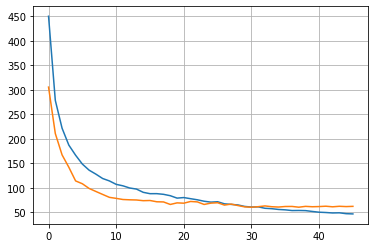

In [35]:
for name, values in history_final.history.items():
    plt.plot(values)
    plt.grid("True")

In [36]:
test_ds = timeseries_dataset_from_df(test, data_config["batch_size"])
mse = model_final.evaluate(test_ds)
print(f"Test RMSE: {mse**.5:.4f}")

561/561 [==============================] - 2s 3ms/step - loss: 69.4606
Test RMSE: 8.3343


## Run with lower LSTM Layers , 64 Neurons

In [38]:
# define our model
from tensorflow.keras.layers import Dropout
model_config = {"n_epochs": 100, "n_neurons":64,
                  "dropout": 0.2, "stateful": False}

def models():
  
  model = Sequential()
  model.add(
      LSTM(
          model_config["n_neurons"],
          # usually set to (`batch_size`, `sequence_length`, `n_features`)
          # setting the batch size to None allows for variable length batches
          batch_input_shape=(None, data_config["timesteps"], len(XCOLS)),
          stateful=model_config["stateful"],
          dropout=model_config["dropout"],
          activation='relu',kernel_regularizer='l2',
      )
  )
 
  model.add(Dense(32,kernel_regularizer='l2'))
  model.add(Dropout(0.4))
  model.add(Dense(32,kernel_regularizer='l2'))
  model.add(Dropout(0.4))
  #model.add(Dense())
  model.add(Dense(len(YCOLS)))
  opt=Adam(learning_rate=0.00001)
  model.compile(
      loss="mean_squared_error",
      optimizer=opt,
  )
  return model

In [39]:
model_final2=models()
model_final2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                19968     
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 66        
Total params: 23,170
Trainable params: 23,170
Non-trainable params: 0
__________________________________________________

In [40]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
history_final2 = model_final2.fit(
    train_ds,
    batch_size=data_config["batch_size"],
    epochs=model_config["n_epochs"],
    verbose=1,
    shuffle=False,
    validation_data=val_ds,
    callbacks=[es]
)

Epoch 1/100
3245/3245 [==============================] - 25s 7ms/step - loss: 594.9814 - val_loss: 240.8792
Epoch 2/100
3245/3245 [==============================] - 26s 8ms/step - loss: 319.5664 - val_loss: 157.4719
Epoch 3/100
3245/3245 [==============================] - 27s 8ms/step - loss: 234.8050 - val_loss: 121.2628
Epoch 4/100
3245/3245 [==============================] - 27s 8ms/step - loss: 196.4660 - val_loss: 98.3864
Epoch 5/100
3245/3245 [==============================] - 24s 7ms/step - loss: 171.0773 - val_loss: 88.2964
Epoch 6/100
3245/3245 [==============================] - 24s 7ms/step - loss: 148.3712 - val_loss: 79.6263
Epoch 7/100
3245/3245 [==============================] - 22s 7ms/step - loss: 135.0063 - val_loss: 77.3529
Epoch 8/100
3245/3245 [==============================] - 24s 7ms/step - loss: 125.4198 - val_loss: 75.5090
Epoch 9/100
3245/3245 [==============================] - 23s 7ms/step - loss: 118.0414 - val_loss: 72.8750
Epoch 10/100
3245/3245 [==========

3245/3245 [==============================] - 23s 7ms/step - loss: 43.8437 - val_loss: 39.0494
Epoch 78/100
3245/3245 [==============================] - 22s 7ms/step - loss: 43.8050 - val_loss: 38.0131
Epoch 79/100
3245/3245 [==============================] - 23s 7ms/step - loss: 43.7497 - val_loss: 39.0908
Epoch 80/100
3245/3245 [==============================] - 24s 7ms/step - loss: 44.1857 - val_loss: 38.5220
Epoch 81/100
3245/3245 [==============================] - 23s 7ms/step - loss: 43.3628 - val_loss: 37.2212
Epoch 82/100
3245/3245 [==============================] - 22s 7ms/step - loss: 41.2562 - val_loss: 38.1636
Epoch 83/100
3245/3245 [==============================] - 22s 7ms/step - loss: 41.9535 - val_loss: 39.0416
Epoch 84/100
3245/3245 [==============================] - 23s 7ms/step - loss: 42.4462 - val_loss: 38.8576
Epoch 85/100
3245/3245 [==============================] - 24s 7ms/step - loss: 41.9870 - val_loss: 39.6198
Epoch 86/100
3245/3245 [==========================

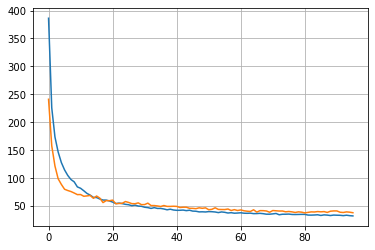

In [41]:
for name, values in history_final2.history.items():
    plt.plot(values)
    plt.grid("True")

In [42]:
test_ds = timeseries_dataset_from_df(test, data_config["batch_size"])
mse = model_final2.evaluate(test_ds)
print(f"Test RMSE: {mse**.5:.4f}")

561/561 [==============================] - 2s 3ms/step - loss: 39.9018: 0s
Test RMSE: 6.3168


In [43]:
# define our model
from tensorflow.keras.layers import Dropout
model_config = {"n_epochs": 100, "n_neurons": 32,
                  "dropout": 0.25, "stateful": False}

def models():
  
  model = Sequential()
  model.add(
      LSTM(
          model_config["n_neurons"],
          # usually set to (`batch_size`, `sequence_length`, `n_features`)
          # setting the batch size to None allows for variable length batches
          batch_input_shape=(None, data_config["timesteps"], len(XCOLS)),
          stateful=model_config["stateful"],
          dropout=model_config["dropout"],
          activation='relu',kernel_regularizer='l2',
      )
  )
 
  model.add(Dense(32,kernel_regularizer='l2'))
  model.add(Dropout(0.25))
  model.add(Dense(32,kernel_regularizer='l2'))
  model.add(Dropout(0.25))
  #model.add(Dense())
  model.add(Dense(len(YCOLS)))
  opt=Adam(learning_rate=0.00001)
  model.compile(
      loss="mean_squared_error",
      optimizer=opt,
  )
  return model

In [44]:
model_final3=models()
model_final3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 32)                5888      
_________________________________________________________________
dense_12 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 66        
Total params: 8,066
Trainable params: 8,066
Non-trainable params: 0
____________________________________________________

In [45]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
history_final3 = model_final3.fit(
    train_ds,
    batch_size=data_config["batch_size"],
    epochs=model_config["n_epochs"],
    verbose=1,
    shuffle=False,
    validation_data=val_ds,
    callbacks=[es]
)

Epoch 1/100
3245/3245 [==============================] - 28s 8ms/step - loss: 987.0764 - val_loss: 302.9318
Epoch 2/100
3245/3245 [==============================] - 25s 8ms/step - loss: 349.9491 - val_loss: 173.7319
Epoch 3/100
3245/3245 [==============================] - 26s 8ms/step - loss: 241.3831 - val_loss: 146.3287
Epoch 4/100
3245/3245 [==============================] - 26s 8ms/step - loss: 210.0412 - val_loss: 126.6986
Epoch 5/100
3245/3245 [==============================] - 22s 7ms/step - loss: 191.0646 - val_loss: 116.2241
Epoch 6/100
3245/3245 [==============================] - 21s 7ms/step - loss: 173.3399 - val_loss: 105.0707
Epoch 7/100
3245/3245 [==============================] - 21s 7ms/step - loss: 155.4615 - val_loss: 98.9005
Epoch 8/100
3245/3245 [==============================] - 20s 6ms/step - loss: 150.5219 - val_loss: 89.0824
Epoch 9/100
3245/3245 [==============================] - 21s 6ms/step - loss: 135.4175 - val_loss: 82.0889
Epoch 10/100
3245/3245 [=======

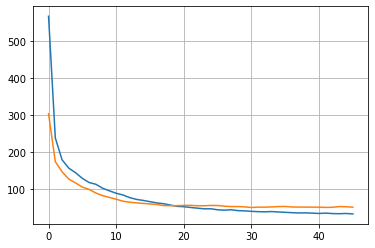

In [46]:
for name, values in history_final3.history.items():
    plt.plot(values)
    plt.grid("True")

In [47]:
test_ds = timeseries_dataset_from_df(test, data_config["batch_size"])
mse = model_final3.evaluate(test_ds)
print(f"Test RMSE: {mse**.5:.4f}")

561/561 [==============================] - 2s 3ms/step - loss: 54.6618
Test RMSE: 7.3934


In [48]:
import json
import pickle

model_final2.save("model")

with open("scaler.pck", "wb") as f:
    pickle.dump(scaler, f)

data_config["solar_wind_subset"] = SOLAR_WIND_FEATURES
print(data_config)
with open("config.json", "w") as f:
    json.dump(data_config, f)

INFO:tensorflow:Assets written to: model/assets
{'timesteps': 16, 'batch_size': 32, 'solar_wind_subset': ['bx_gse', 'by_gse', 'bz_gse', 'speed', 'density', 'temperature', 'theta_gse']}
